# Setup

In [13]:
import os
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Data

## Fetch Data

In [2]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/.kaggle'

!kaggle datasets download -d hassanrevel/plantsspecies

import zipfile
with zipfile.ZipFile('plantsspecies.zip', 'r') as f:
  f.extractall('')

Dataset URL: https://www.kaggle.com/datasets/hassanrevel/plantsspecies
License(s): MIT
100% 3.29G/3.29G [02:59<00:00, 19.6MB/s]
100% 3.29G/3.29G [02:59<00:00, 19.7MB/s]


## Data Load

In [3]:
# Define transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Define transformations for validation and test (without data augmentation)
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to fixed size
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [4]:
def data_loader(path, batch_size, num_workers):
  # Load training, validation, and test datasets using ImageFolder with transformations
  train_dataset = datasets.ImageFolder(f'{path}/train', transform=train_transform)
  val_dataset = datasets.ImageFolder(f'{path}/valid', transform=valid_transform)
  test_dataset = datasets.ImageFolder(f'{path}/test', transform=valid_transform)

  # Create data loaders for training, validation, and test sets
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=32,
                                             shuffle=True, num_workers=num_workers)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                           shuffle=False, num_workers=num_workers)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                            shuffle=False, num_workers=num_workers)

  return train_loader, val_loader, test_loader

# Model

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(VisionTransformer, self).__init__()
        self.backbone = models.vit_b_16(pretrained=pretrained)  # Load pretrained ViT backbone
        self.backbone.heads = nn.Linear(self.backbone.heads.head.in_features, num_classes)  # Change output to num_classes

    def forward(self, x):
        x = self.backbone(x)
        return x

# Training

In [6]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    epoch_loss = []
    all_labels = []
    all_preds = []

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        # model forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record loss
        epoch_loss.append(loss.item())

        # Convert outputs to predictions
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Compute accuracy and F1 score
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return np.mean(epoch_loss), epoch_acc, epoch_f1

In [7]:
def val(val_loader, model, criterion, device):
    model.eval()
    val_loss = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())

            # Convert outputs to predictions
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute accuracy and F1 score
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return np.mean(val_loss), val_acc, val_f1

In [8]:
def trainer(train_loader, val_loader, model, criterion, optimizer, device, epochs, model_save_path):
    best_val_f1 = 0.0  # Initialize best F1 score
    metrics = {
        "train_losses": [],
        "train_accs": [],
        "train_f1s": [],
        "val_losses": [],
        "val_accs": [],
        "val_f1s": []
    }

    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}/{epochs}')

        train_loss, train_acc, train_f1 = train(train_loader, model, criterion, optimizer, device)
        val_loss, val_acc, val_f1 = val(val_loader, model, criterion, device)

        # Check if current F1 score is the best so far
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print('F1 Score increased, saving the model at', model_save_path)

        # Print progress
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")
        print(f"Train F1: {train_f1:.2f}, Val F1: {val_f1:.2f}")

        metrics["train_losses"].append(train_loss)
        metrics["train_accs"].append(train_acc)
        metrics["train_f1s"].append(train_f1)
        metrics["val_losses"].append(val_loss)
        metrics["val_accs"].append(val_acc)
        metrics["val_f1s"].append(val_f1)

    return metrics

# Experimentations

## Hyperparameters

In [9]:
BATCH_SIZE = 32
DATA_DIR = "PlantsSpecies"

LEARNING_RATE = 0.001
EPOCHS = 5

NAME = "ViTExp"
ROOT_DIR = "/content/drive/MyDrive"
VERSION = "0.1"


BEST_MODEL_SAVE_PATH = f'{ROOT_DIR}/models/{NAME}/model_{VERSION}_best.pth'

# MODEL_LOAD_PATH = 'model_v0.1_best.pth'

MODEL_SAVE_PATH = f'{ROOT_DIR}/models/{NAME}/model_{VERSION}_ep{EPOCHS}.pth'
METRICS_SAVE_PATH = f'{ROOT_DIR}/reports/metrics/{NAME}/metrics_{VERSION}_ep{EPOCHS}.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 2

## Training

In [10]:
# Data loading
train_loader, val_loader, test_loader = data_loader(DATA_DIR, BATCH_SIZE, NUM_WORKERS)

# Model
model = VisionTransformer(len(os.listdir(os.path.join(DATA_DIR, 'train')))).to(device)

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Loss function
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 54.1MB/s]


In [11]:
# model.load_state_dict(torch.load(MODEL_LOAD_PATH))

In [12]:
# Training the model

metrics = trainer(train_loader, val_loader,
                  model, criterion,
                  optimizer, device, EPOCHS,
                  model_save_path=BEST_MODEL_SAVE_PATH)

Epoch: 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a2e2d355480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a2e2d355480>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-pa

F1 Score increased, saving the model at /content/drive/MyDrive/models/ViTExp/model_0.1_best.pth
Train Loss: 2.3229, Val Loss: 2.1650
Train Acc: 0.20, Val Acc: 0.22
Train F1: 0.13, Val F1: 0.09
Epoch: 2/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score increased, saving the model at /content/drive/MyDrive/models/ViTExp/model_0.1_best.pth
Train Loss: 2.0299, Val Loss: 1.9857
Train Acc: 0.29, Val Acc: 0.38
Train F1: 0.20, Val F1: 0.27
Epoch: 3/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.8559, Val Loss: 2.2489
Train Acc: 0.34, Val Acc: 0.15
Train F1: 0.27, Val F1: 0.05
Epoch: 4/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.7287, Val Loss: 1.6845
Train Acc: 0.40, Val Acc: 0.36
Train F1: 0.32, Val F1: 0.26
Epoch: 5/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a2e2d355480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a2e2d355480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tor

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score increased, saving the model at /content/drive/MyDrive/models/ViTExp/model_0.1_best.pth
Train Loss: 1.6299, Val Loss: 1.3013
Train Acc: 0.44, Val Acc: 0.64
Train F1: 0.38, Val F1: 0.58


## Results

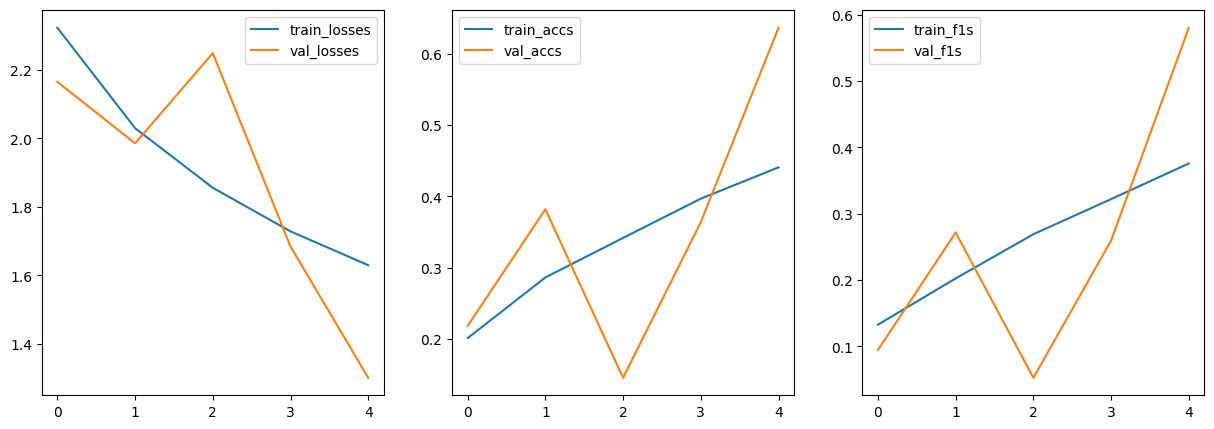

In [15]:
r = pd.DataFrame(metrics)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
r[['train_losses', 'val_losses']].plot(ax=ax[0])
r[['train_accs', 'val_accs']].plot(ax=ax[1])
r[['train_f1s', 'val_f1s']].plot(ax=ax[2])
plt.show()

In [16]:
print('Validation F1 Score....')
r[r['val_f1s'] == r['val_f1s'].max()]

Validation F1 Score....


,train_losses,train_accs,train_f1s,val_losses,val_accs,val_f1s
4,1.629932,0.440592,0.375587,1.301287,0.636364,0.580068


## Saving

In [17]:
# Saving model
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [18]:
# Saving metrics
os.makedirs(os.path.dirname(METRICS_SAVE_PATH), exist_ok=True)

r.to_csv(METRICS_SAVE_PATH, index=False)